### Introduction

We want to explore the relationship between vacant homes and house prices, to understand what effect vacant homes have on the housing market and how this has changed over time. 

Simplistically, we could plot the number of vacant homes against the average house price for lots of places in England. But this wouldn't account for inflation or regional population and housing differences.

To account for inflation, we'll use the [median house price to residence based earnings ratio](https://www.ons.gov.uk/peoplepopulationandcommunity/housing/datasets/ratioofhousepricetoresidencebasedearningslowerquartileandmedian). This is published by the Office for National Statistics (ONS) and is available at local authority level. Residence based earnings, for a given local authority, are counted based on where people live, rather than their place of work (which could be in a different local authority).

To account for regional population/housing differences, we will use the number of vacant homes per 1000 dwellings. This is calculated by dividing the respective counts in [Table 615: vacant dwellings by local authority district: England, from 2004](https://www.gov.uk/government/statistical-data-sets/live-tables-on-dwelling-stock-including-vacants) by the dwelling count estimates in [Table 125: dwelling stock estimates by local authority district](https://www.gov.uk/government/statistical-data-sets/live-tables-on-dwelling-stock-including-vacants) and multiplying by 1000. This gives a relative number of vacant homes that is porportional to the total number of dwellings in a given local authority.

The aim is to make a scatter plot of house price to earnings ratio against vacant homes per 1000 dwellings. Each point on the plot will be a single local authority, and we'll make 3 of these plots for 2004 (the earliest common year in both datasets), 2014, and 2023 (the most recent year in both datasets).

### Method

First, we will import all the modules we're going to need. We also need to set up our file paths so that anyone who cloned this repo could run this notebook.

In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ROOT = Path('../')
ROOT.resolve()

PosixPath('/Users/lukestrange/Code/housing')

Read in the data we need. We processed this already so it will be straightforward to combine it into one table.

In [2]:
hp_wage_ratio = pd.read_parquet(ROOT / 'data/house-prices/site/hp_to_wage_ratio.parquet')
vh = pd.read_csv(ROOT / 'data/vacant-homes/standard/AllCombined_Cleaned_2024.csv')

In [3]:
# Convert date to int type
hp_wage_ratio['date'] = hp_wage_ratio['date'].astype(int)

# Add a more useful column name
hp_wage_ratio.rename(columns={'value':'wage_ratio'}, inplace=True)

Vacant homes and dwellings data are stored in the same file. We'll use a copy of `vh` to filter these out respectively.

In [4]:
vacant_homes = vh.copy()
vacant_homes = vacant_homes[vacant_homes['Measure'] == 'AllVacants']
vacant_homes['date'] = vacant_homes['date'].astype(int)
vacant_homes.rename(columns={'Value': 'AllVacants'}, inplace=True)

In [5]:
dwellings = vh.copy()
dwellings = dwellings[dwellings['Measure'] == 'Dwellings']
dwellings['date'] = dwellings['date'].astype(int)
dwellings.rename(columns={'Value': 'Dwellings'}, inplace=True)

In [6]:
# Merge all three dataframes into one.
combined = vacant_homes.merge(hp_wage_ratio, on=['geography_code', 'date'], how='inner').merge(dwellings, on=['geography_code', 'date'], how='inner')

# Calculate the number of vacant homes per 1000 dwellings
combined['vacants_per_thousand_dwellings'] = (1000 * combined['AllVacants'] / combined['Dwellings']).round()

# Only include Local authority districts. No aggregates like regions, counties etc.
combined = combined[combined.geography_code.str.startswith(("E06", "E07", "E08", "E09"))]

# Add a column that says whether or not the local authority is a London Borough (E09 codes).
combined['London borough'] = combined.geography_code.str.startswith('E09')

A quick note here to say that in the final line above, we exlcude anything that isn't a local authority district (so no counties, regions etc.). This is so that there are no aggregations of the data that is already being displayed.

Below, we will import some modules and write some code to plot the data on a scatterplot. We'll write this as a function since we will re-use it for individual year's data.

In [7]:
# Set the font to Arial
plt.rcParams["font.sans-serif"] = ["Arial"] 

def make_scatterplot(data, year):
    # Filter the data by year
    single_year = data[data.date == year]
    # Make the scatterplot
    ax = sns.scatterplot(data=single_year, x='vacants_per_thousand_dwellings', y='wage_ratio', hue='London borough')
    # Set some params
    ax.set(xlabel='Vacant Homes per 1000 Dwellings', ylabel='House price to residence-based earnings ratio', title=str(year), xlim=(0, 100), ylim=(0, 25))
    # Rename the legend
    ax.legend(title='Location')
    # Rename the legend items to be more informative
    handles, previous_labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=['Not London Boroughs (E06, E07, E08)', 'London Boroughs (E09)'])
    # Save the figure
    plt.savefig(ROOT / f"src/assets/images/vacant_homes_house_prices_to_wage_ratio/{year}.png")
    # Show the figure
    plt.show()
    return

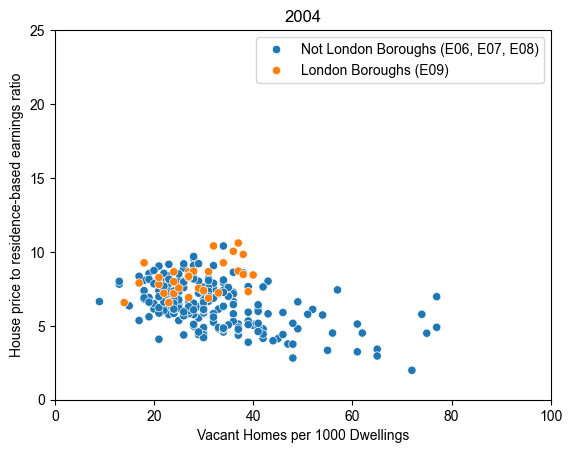

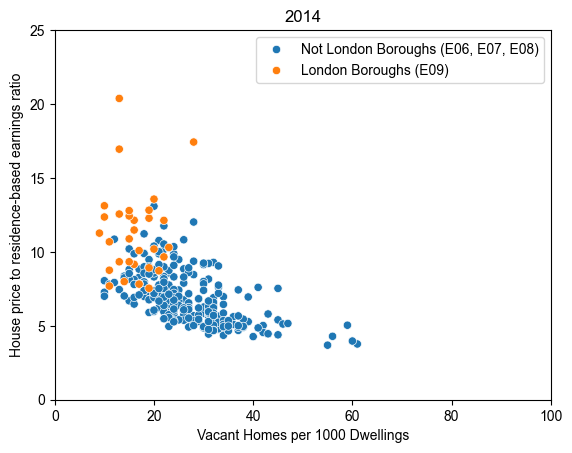

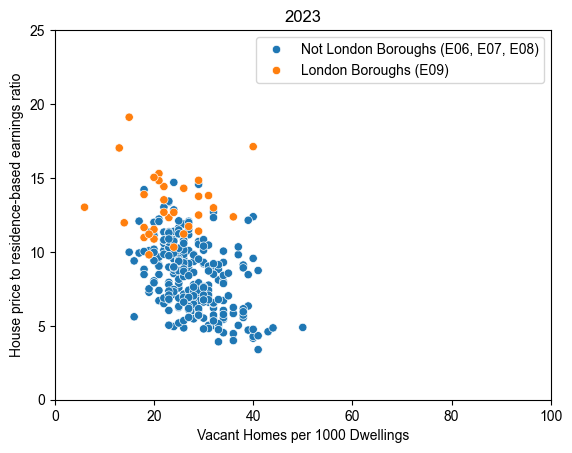

In [8]:
make_scatterplot(combined, 2004)
make_scatterplot(combined, 2014)
make_scatterplot(combined, 2023)